In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
import pandas as pd
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import nltk
nltk.download('stopwords')
import numpy as np
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\poula\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\poula\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\poula\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns',200)

### Parts 1 and 2


In [3]:
df=pd.read_csv(r'Project1CSV.csv')

In [4]:
df.describe()

,Sentiment
count,300.000000
mean,0.506667
std,0.500791
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [5]:
df.groupby(['Company'])['Sentiment'].mean() #getting an understanding of the sentiments around the companies for timeframe- Oct 2019 till July 2020

Company
Airbus               0.3
Alibaba              0.8
Amazon               0.4
American Airlines    0.2
Apple                0.5
Bank of America      0.8
Boeing               0.2
Citigroup            0.5
Deutsche Bank        0.3
Disney               0.4
Exxon Mobil          0.7
Facebook             0.5
Fiat Chrysler        0.6
Ford Motors          0.6
Goldman Sachs        0.7
Google               0.5
Huawei               0.3
JP Morgan            0.7
Johnson & Johnson    0.3
Lyft                 0.6
Microsoft            0.7
Morgan Stanley       0.5
Netflix              0.7
Nissan               0.5
Pfizer               0.5
Tesla                0.3
Uber                 0.6
Verizon              0.4
Walmart              0.6
Wells Fargo          0.5
Name: Sentiment, dtype: float64

In [6]:
df["new_date"] = pd.to_datetime(df.Date)

In [7]:
df['Combined_Headlines'] = df['Combined_Headlines'].astype(str)

In [8]:
df = df.sort_values('Company')
df = df.reset_index(drop=True)

In [9]:
shuffle(df,random_state=13) #we use this so we can subset training data later for NBC classifer and create a reproducable train test split.
df

,Headlines,Date,Month,Subheadlines,Company,Sentiment,Combined_Headlines,new_date
0,"Airbus in talks with French state, no liquidit...",4/30/2020,April,European planemaker Airbus is in talks with t...,Airbus,0,"Airbus in talks with French state, no liquidit...",2020-04-30
1,"Air France axes A380, Emirates seen cutting de...",5/20/2020,May,"The world's largest airliner, the Airbus A380...",Airbus,0,"Air France axes A380, Emirates seen cutting de...",2020-05-20
2,Record $4 billion Airbus fine draws line under...,1/31/2020,January,Airbus bribed public officials and hid the pay...,Airbus,0,Record $4 billion Airbus fine draws line under...,2020-01-31
3,Airbus considering production of hybrid airpla...,11/29/2019,November,Airbus is considering producing a hybrid pla...,Airbus,1,Airbus considering production of hybrid airpla...,2019-11-29
4,Airbus struggles to lift crisis-hit jet output,3/30/2020,March,Europe's Airbus is grappling with labor and s...,Airbus,0,Airbus struggles to lift crisis-hit jet output...,2020-03-30
...,...,...,...,...,...,...,...,...
295,Wells Fargo files for up to $66 billion mixed ...,1/29/2020,January,Wells Fargo & Co filed a mixed shelf offering...,Wells Fargo,0,Wells Fargo files for up to $66 billion mixed ...,2020-01-29
296,Wells Fargo will cut costs further after first...,7/14/2020,July,Wells Fargo & Co will launch a broad cost-cutt...,Wells Fargo,0,Wells Fargo will cut costs further after first...,2020-07-14
297,U.S. bank shares drop as Fed sets limits follo...,6/26/2020,June,"Shares of U.S. banks dropped on Friday, with W...",Wells Fargo,0,U.S. bank shares drop as Fed sets limits follo...,2020-06-26
298,Senior U.S. lawmaker to seek testimony of Well...,12/19/2019,December,A U.S. congressional committee will ask Wells ...,Wells Fargo,0,Senior U.S. lawmaker to seek testimony of Well...,2019-12-19


### Parts 3 and 4

In [11]:
def get_wordnet_pos(tag):
    # Return whether "tag" is adjective, 
    # noun, verb or adverb
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN



In [12]:
sw = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
  tokens = text.lower().split() #lowercases and splits the tokens
  tokens = [re.sub('[^A-Za-z]',' ',el) for el in tokens]  #takes out numbers and punctutations
  tokens = [re.sub('https[a-z]*',' ', el) for el in tokens] # takes out the url tags
  return ' '.join(tokens)

In [13]:
df['cleaned_text'] = df.Combined_Headlines.apply(clean_text)

In [14]:
df.head()

,Headlines,Date,Month,Subheadlines,Company,Sentiment,Combined_Headlines,new_date,cleaned_text
0,"Airbus in talks with French state, no liquidit...",4/30/2020,April,European planemaker Airbus is in talks with t...,Airbus,0,"Airbus in talks with French state, no liquidit...",2020-04-30,airbus in talks with french state no liquidit...
1,"Air France axes A380, Emirates seen cutting de...",5/20/2020,May,"The world's largest airliner, the Airbus A380...",Airbus,0,"Air France axes A380, Emirates seen cutting de...",2020-05-20,air france axes a emirates seen cutting de...
2,Record $4 billion Airbus fine draws line under...,1/31/2020,January,Airbus bribed public officials and hid the pay...,Airbus,0,Record $4 billion Airbus fine draws line under...,2020-01-31,record billion airbus fine draws line under...
3,Airbus considering production of hybrid airpla...,11/29/2019,November,Airbus is considering producing a hybrid pla...,Airbus,1,Airbus considering production of hybrid airpla...,2019-11-29,airbus considering production of hybrid airpla...
4,Airbus struggles to lift crisis-hit jet output,3/30/2020,March,Europe's Airbus is grappling with labor and s...,Airbus,0,Airbus struggles to lift crisis-hit jet output...,2020-03-30,airbus struggles to lift crisis hit jet output...


In [15]:
#print(df.iloc[36, -1]) # just for demonstration purposes- this had a url tag but now it doesn't anymore

In [16]:
def cleaner_text(text):
  tokens= text.split()
  tokens = [el for el in tokens if el not in sw] #takes out stopwords
  tokens_pos = nltk.pos_tag(tokens) #giving string index out of range error
  tokens = [lemmatizer.lemmatize(el[0],get_wordnet_pos(el[1])) for  el in tokens_pos]
  return ' '.join(tokens)

In [17]:
df['cleaner_text'] = df.cleaned_text.apply(cleaner_text)

In [18]:
df['cleaner_text'].head()

0    airbus talk french state liquidity concern pre...
1    air france ax emirates see cut delivery world ...
2    record billion airbus fine draw line pervasive...
3    airbus consider production hybrid airplane air...
4    airbus struggle lift crisis hit jet output eur...
Name: cleaner_text, dtype: object

In [19]:
#print(df.iloc[36, -1]) # just for demonstration purposes- this had a url tag but now it doesn't anymore

In [20]:
df['Combined_Headlines'].iloc[10]

"Beyond Meat to sell patties in mainland China through Freshippo stores : Beyond Meat Inc  said on Tuesday that it will launch retail sales of its plant-based burger patties in mainland China through Alibaba Group Holding Ltd's  Freshippo markets."

In [21]:
df['cleaned_text'].iloc[10]

'beyond meat to sell patties in mainland china through freshippo stores   beyond meat inc said on tuesday that it will launch retail sales of its plant based burger patties in mainland china through alibaba group holding ltd s freshippo markets '

In [22]:
df['cleaner_text'].iloc[10]

'beyond meat sell patty mainland china freshippo store beyond meat inc say tuesday launch retail sale plant base burger patty mainland china alibaba group hold ltd freshippo market'

### Part 5

In [23]:
vect=TfidfVectorizer()
Y = vect.fit_transform(df.cleaner_text) 

tfidf = pd.DataFrame(columns=vect.get_feature_names(),
                           data = Y.toarray())
tfidf

,ability,able,abort,abuse,accelerate,acceleration,accept,access,accident,accord,account,accusation,accuse,achieve,achleitner,acknowledge,acquire,acquisition,across,action,active,activist,activity,ad,adapt,add,additional,address,adequate,adequately,administration,admit,advance,advantage,adverse,advertise,advertisement,advertiser,advertising,advice,adviser,advisor,advisory,aerial,affect,affidavit,affiliate,afp,africa,ag,age,agence,agency,aggregator,agree,agreement,ahead,aid,aim,air,airasia,airbus,aircraft,aircrew,airline,airliner,airplane,airpods,airtel,airway,akeso,alabama,albertsons,alex,alibaba,allay,allegation,allege,alleged,allen,alliance,allow,ally,almost,alphabet,already,also,alter,although,amazon,ambition,amends,america,american,americans,amf,amid,among,amount,analysis,...,verdict,verily,verizon,version,vestager,veteran,viacom,victim,victory,video,view,vintage,violate,violation,virus,visible,vivendi,vnxhyw,vodafone,volume,vote,voucher,vulnerable,vyndaqel,wake,waldron,walkout,wall,wallflower,walmart,walt,want,wanzhou,war,warehouse,warn,warning,warns,warren,washington,watchdog,watched,weak,weakness,weaknesses,wealth,wear,weather,website,wednesday,week,weekend,weekly,weigh,weighs,well,welt,wheel,whether,whitney,wide,widely,win,wind,winner,wirecard,wireless,wirth,withdraw,withdrew,withhold,within,without,woman,word,work,worker,workforce,workplace,workshop,world,worldwide,worry,worth,worthless,would,wrong,wsj,www,xbox,xinhua,year,yen,yet,york,youtube,yuan,zomato,zte,zuckerberg
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.401936,0.140218,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.325465,0.0,0.147284,0.000000,0.0,0.0,0.205551,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106761,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.134478,0.000000,0.0,0.0,0.0,0.11535,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17104,0.0,0.0,0.0,0.0,0.000000,0.0,0.299896,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [24]:
max = tfidf.max().max()
highTFIDF= tfidf.where(tfidf==max)
list(highTFIDF.stack().index)

[(137, 'changan')]

In [25]:
#here we are getting the document-term matrix
vect = CountVectorizer()
vect.fit(df.cleaner_text)
headlines_dtm = vect.transform(df.cleaner_text)
headlines_dtm_df = pd.DataFrame(headlines_dtm.toarray(), 
                              columns=vect.get_feature_names())
headlines_dtm_df.head()

,ability,able,abort,abuse,accelerate,acceleration,accept,access,accident,accord,account,accusation,accuse,achieve,achleitner,acknowledge,acquire,acquisition,across,action,active,activist,activity,ad,adapt,add,additional,address,adequate,adequately,administration,admit,advance,advantage,adverse,advertise,advertisement,advertiser,advertising,advice,adviser,advisor,advisory,aerial,affect,affidavit,affiliate,afp,africa,ag,age,agence,agency,aggregator,agree,agreement,ahead,aid,aim,air,airasia,airbus,aircraft,aircrew,airline,airliner,airplane,airpods,airtel,airway,akeso,alabama,albertsons,alex,alibaba,allay,allegation,allege,alleged,allen,alliance,allow,ally,almost,alphabet,already,also,alter,although,amazon,ambition,amends,america,american,americans,amf,amid,among,amount,analysis,...,verdict,verily,verizon,version,vestager,veteran,viacom,victim,victory,video,view,vintage,violate,violation,virus,visible,vivendi,vnxhyw,vodafone,volume,vote,voucher,vulnerable,vyndaqel,wake,waldron,walkout,wall,wallflower,walmart,walt,want,wanzhou,war,warehouse,warn,warning,warns,warren,washington,watchdog,watched,weak,weakness,weaknesses,wealth,wear,weather,website,wednesday,week,weekend,weekly,weigh,weighs,well,welt,wheel,whether,whitney,wide,widely,win,wind,winner,wirecard,wireless,wirth,withdraw,withdrew,withhold,within,without,woman,word,work,worker,workforce,workplace,workshop,world,worldwide,worry,worth,worthless,would,wrong,wsj,www,xbox,xinhua,year,yen,yet,york,youtube,yuan,zomato,zte,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
#code for getting max tf from the above document term matrix

max = headlines_dtm_df.max().max()
highTF= headlines_dtm_df.where(headlines_dtm_df==max)
list(highTF.stack().index)

[(47, 'eu')]

In [27]:
#code for getting max idf from the above document term matrix
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(headlines_dtm)
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=vect.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])


,idf_weights
say,1.670158
inc,1.988611
coronavirus,2.458615
co,2.699777
company,2.718126
...,...
denounce,6.013963
organise,6.013963
orange,6.013963
others,6.013963


In [28]:
print(df_idf.idxmax())
print(df_idf.max())

idf_weights    abort
dtype: object
idf_weights    6.013963
dtype: float64


In [29]:
#tfidf.risk.where(tfidf['risk'] != 0).dropna()

#highTFIDF= tfidf.where(tfidf>0.55)
#list(highTFIDF.stack().index)

We calculated TF by first creating a document-term matrix through a CountVectorizer. From that, we are able to find the word with the highest term frequency was "EU". We used the TFIDFTransformer to calculate IDF, which "abort" being the word with the highest IDF value. The highest TFIDF weight was around 0.59, and was assigned the word "Changan", which is a company name. This makes sense, since it is mentioned 3 times in one article and never again throughout the rest of the corpus.

### Part 6

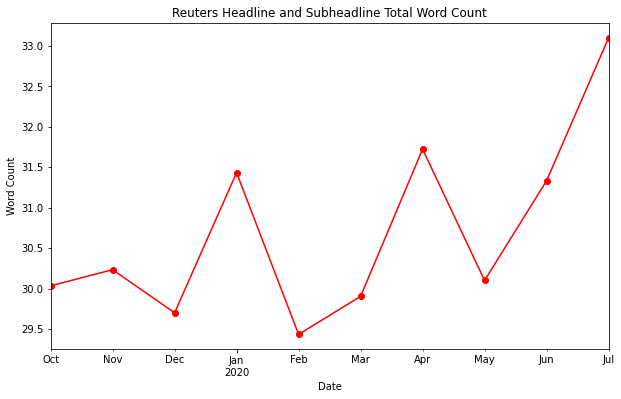

In [30]:
plt.figure(figsize=(10,6))
df['word_count'] = df['cleaner_text'].str.count(' ') + 1
df.resample('M', on='new_date')['word_count'].mean().plot(marker='o',color='r')
plt.title('Reuters Headline and Subheadline Total Word Count')
plt.ylabel('Word Count')
plt.xlabel('Date')

plt.show()

### Part 7


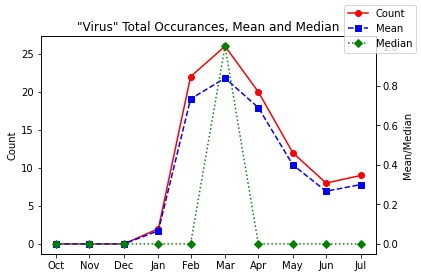

In [31]:
df['virus_occurances'] = df['cleaner_text'].str.findall(r"\w+virus")
df['virus_count'] = df.virus_occurances.apply(len)
fig,ax1=plt.subplots()
sum = df.resample('M', on='new_date')['virus_count'].sum()
ax1.plot(sum,marker='o',color='r',label='Count')
ax2 = ax1.twinx()
mean = df.resample('M', on='new_date')['virus_count'].mean()
ax2.plot(mean,marker='s',color='b',label='Mean',linestyle='--')
median = df.resample('M', on='new_date')['virus_count'].median()
ax2.plot(median,marker='D',color='g',label='Median',linestyle=':')
plt.title('"Virus" Total Occurances, Mean and Median')
plt.xlabel('Date')
ax1.set_ylabel('Count')
ax2.set_ylabel('Mean/Median')
fig.legend(loc="upper right")
months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul']
plt.xticks(sum.index, months)
plt.show()

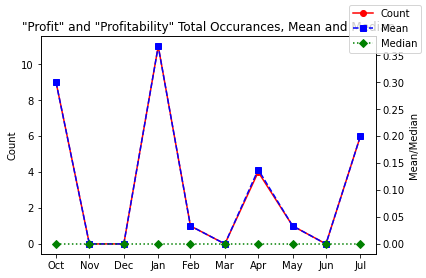

In [32]:
df['profit_occurances'] = df['cleaner_text'].str.findall(r"profi\w+")
df['profit_count'] = df.profit_occurances.apply(len)
fig,ax1=plt.subplots()
sum = df.resample('M', on='new_date')['profit_count'].sum()
ax1.plot(sum,marker='o',color='r',label='Count')
ax2 = ax1.twinx()
mean = df.resample('M', on='new_date')['profit_count'].mean()
ax2.plot(mean,marker='s',color='b',label='Mean',linestyle='--')
median = df.resample('M', on='new_date')['profit_count'].median()
ax2.plot(median,marker='D',color='g',label='Median',linestyle=':')
plt.title('"Profit" and "Profitability" Total Occurances, Mean and Median')
plt.xlabel('Date')
ax1.set_ylabel('Count')
ax2.set_ylabel('Mean/Median')
fig.legend(loc="upper right")
plt.xticks(sum.index, months)
plt.show()

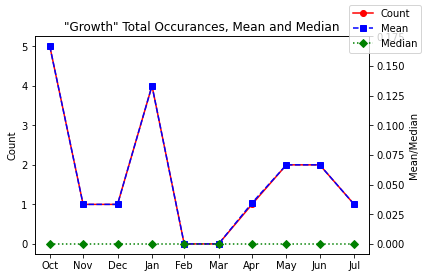

In [69]:
df['growth_occurances'] = df['cleaner_text'].str.findall(r"growth")
df['growth_count'] = df.growth_occurances.apply(len)
fig,ax1=plt.subplots()
sum = df.resample('M', on='new_date')['growth_count'].sum()
ax1.plot(sum,marker='o',color='r',label='Count')
ax2 = ax1.twinx()
mean = df.resample('M', on='new_date')['growth_count'].mean()
ax2.plot(mean,marker='s',color='b',label='Mean',linestyle='--')
median = df.resample('M', on='new_date')['growth_count'].median()
ax2.plot(median,marker='D',color='g',label='Median',linestyle=':')
plt.title('"Growth" Total Occurances, Mean and Median')
plt.xlabel('Date')
ax1.set_ylabel('Count')
ax2.set_ylabel('Mean/Median')
fig.legend(loc="upper right")
plt.xticks(sum.index, months)
plt.show()

Looking at "virus" (as well as "coronavirus"), there is a large  spike in March, April and May, which falls for the subsequent months. It seems like in April, much of the company news was cenetered around the virus, as it was the only month where the median value of mentions was greater than 0.

We also looked at Profit/Profitability and Growth, and noticed that the mean and count spike around the end of the quarter, when there are likely frequent earnings calls. We also see the spikes in both terms are not as high after March as they were in January and October, perhaps signalling that there is less profit and growth after the coronavirus.

### Part 8 


In [34]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [35]:
nb = MultinomialNB()

In [36]:
X = headlines_dtm_df
y = df.Sentiment
X_train = X.iloc[:210,] #need to explain why we do a manual train test split a lot
X_test = X.iloc[210:,]
y_train = y.iloc[:210,]
y_test = y.iloc[210:,]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(210, 2191)
(90, 2191)
(210,)
(90,)


In [37]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [38]:
y_pred_class = nb.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.6888888888888889

In [39]:
metrics.confusion_matrix(y_test, y_pred_class, labels=[0,1])

array([[27, 17],
       [11, 35]])

In [40]:
metrics.recall_score(y_test.values, y_pred_class, pos_label=1)

0.7608695652173914

In [41]:
metrics.precision_score(y_test.values, y_pred_class, pos_label=1)

0.6730769230769231

In [42]:
y_pred_train = nb.predict(X_train)

In [43]:
y_pred_class

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1])

In [44]:
y_test.head()

210    0
211    1
212    1
213    0
214    0
Name: Sentiment, dtype: int64

In [45]:
predicted_sentiment = np.concatenate([y_pred_train,y_pred_class])

In [46]:
predicted_sentiment #this is why we did a manual split. Train test split randomizes each time, so using that approach would have not lined up the columns. Based on our shuffle code earlier, we have already randomized the data in a random state

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1])

In [47]:
df['predicted_NBC_sentiment'] = predicted_sentiment
df.head()

,Headlines,Date,Month,Subheadlines,Company,Sentiment,Combined_Headlines,new_date,cleaned_text,cleaner_text,word_count,virus_occurances,virus_count,profit_occurances,profit_count,growth_occurances,growth_count,predicted_NBC_sentiment
0,"Airbus in talks with French state, no liquidit...",4/30/2020,April,European planemaker Airbus is in talks with t...,Airbus,0,"Airbus in talks with French state, no liquidit...",2020-04-30,airbus in talks with french state no liquidit...,airbus talk french state liquidity concern pre...,32,[],0,[],0,[],0,0
1,"Air France axes A380, Emirates seen cutting de...",5/20/2020,May,"The world's largest airliner, the Airbus A380...",Airbus,0,"Air France axes A380, Emirates seen cutting de...",2020-05-20,air france axes a emirates seen cutting de...,air france ax emirates see cut delivery world ...,32,[],0,[],0,[],0,0
2,Record $4 billion Airbus fine draws line under...,1/31/2020,January,Airbus bribed public officials and hid the pay...,Airbus,0,Record $4 billion Airbus fine draws line under...,2020-01-31,record billion airbus fine draws line under...,record billion airbus fine draw line pervasive...,31,[],0,[],0,[],0,0
3,Airbus considering production of hybrid airpla...,11/29/2019,November,Airbus is considering producing a hybrid pla...,Airbus,1,Airbus considering production of hybrid airpla...,2019-11-29,airbus considering production of hybrid airpla...,airbus consider production hybrid airplane air...,17,[],0,[],0,[],0,1
4,Airbus struggles to lift crisis-hit jet output,3/30/2020,March,Europe's Airbus is grappling with labor and s...,Airbus,0,Airbus struggles to lift crisis-hit jet output...,2020-03-30,airbus struggles to lift crisis hit jet output...,airbus struggle lift crisis hit jet output eur...,27,[],0,[],0,[],0,0


In [48]:
# words which are most indicative of good sentiment or bad sentiment  
#solution 1 -- which is to use the predicted sentiments to split the dataset 
#into good predicted headlines and bad predicted headlines and getting a document-term matrix of those words inside
#the predicted headlines.

goodna= df.where(df.predicted_NBC_sentiment==1)
good=goodna.dropna()
good.head()


,Headlines,Date,Month,Subheadlines,Company,Sentiment,Combined_Headlines,new_date,cleaned_text,cleaner_text,word_count,virus_occurances,virus_count,profit_occurances,profit_count,growth_occurances,growth_count,predicted_NBC_sentiment
3,Airbus considering production of hybrid airpla...,11/29/2019,November,Airbus is considering producing a hybrid pla...,Airbus,1.0,Airbus considering production of hybrid airpla...,2019-11-29,airbus considering production of hybrid airpla...,airbus consider production hybrid airplane air...,17.0,[],0.0,[],0.0,[],0.0,1.0
7,Airbus A220 engines pass engine checks after r...,10/31/2019,October,Airlines have completed one round of checks tr...,Airbus,1.0,Airbus A220 engines pass engine checks after r...,2019-10-31,airbus a engines pass engine checks after r...,airbus engine pass engine check recent failure...,25.0,[],0.0,[],0.0,[],0.0,1.0
9,Spirit Airlines to buy 100 Airbus A320neo fami...,12/23/2019,December,U.S. budget carrier Spirit Airlines Inc said ...,Airbus,1.0,Spirit Airlines to buy 100 Airbus A320neo fami...,2019-12-23,spirit airlines to buy airbus a neo fami...,spirit airline buy airbus neo family aircraft ...,25.0,[],0.0,[],0.0,[],0.0,1.0
10,Beyond Meat to sell patties in mainland China ...,6/30/2020,June,Beyond Meat Inc said on Tuesday that it will ...,Alibaba,1.0,Beyond Meat to sell patties in mainland China ...,2020-06-30,beyond meat to sell patties in mainland china ...,beyond meat sell patty mainland china freshipp...,28.0,[],0.0,[],0.0,[],0.0,1.0
11,Alibaba demotes top executive after probe into...,4/27/2020,April,Chinese e-commerce giant Alibaba Group Holding...,Alibaba,1.0,Alibaba demotes top executive after probe into...,2020-04-27,alibaba demotes top executive after probe into...,alibaba demotes top executive probe behaviour ...,30.0,[],0.0,[],0.0,[],0.0,1.0


In [49]:
goodsplit=good.cleaner_text.str.split()
def convert(goodsplit): 
    return tuple(goodsplit)

In [50]:
from collections import Counter
goodwords=Counter(x for xs in goodsplit for x in set(xs))
print(goodwords)

Counter({'say': 83, 'inc': 60, 'coronavirus': 31, 'tuesday': 29, 'u': 27, 'co': 27, 'bank': 26, 'thursday': 25, 'group': 24, 'year': 23, 'billion': 23, 'company': 23, 'friday': 22, 'new': 21, 'wednesday': 20, 'source': 19, 'executive': 18, 'plan': 18, 'china': 16, 'business': 16, 'would': 16, 'sale': 15, 'matter': 15, 'corp': 15, 'chief': 14, 'accord': 14, 'monday': 13, 'market': 13, 'unit': 13, 'two': 13, 'million': 13, 'reuters': 13, 'revenue': 13, 'state': 13, 'launch': 12, 'large': 12, 'profit': 12, 'quarter': 12, 'growth': 12, 'report': 11, 'price': 10, 'exclusive': 10, 'financial': 10, 'world': 10, 'amazon': 10, 'investment': 10, 'deal': 10, 'call': 10, 'see': 10, 'america': 10, 'one': 9, 'familiar': 9, 'outbreak': 9, 'raise': 9, 'people': 9, 'employee': 9, 'service': 9, 'pandemic': 9, 'well': 9, 'back': 9, 'street': 9, 'beat': 9, 'platform': 9, 'set': 9, 'motor': 9, 'goldman': 9, 'sachs': 9, 'ride': 9, 'base': 8, 'alibaba': 8, 'sell': 8, 'big': 8, 'first': 8, 'com': 8, 'network'

In [51]:
#text_counter_dict = {}

#for word in split:
    # Initialize value if word not in dict
    #if word not in text_counter_dict.keys():
        #text_counter_dict[word] = 0
    #Add 1 to the current value of the word
    #text_counter_dict[word]+=1

#print(text_counter_dict)

In [52]:
badna= df.where(df.predicted_NBC_sentiment==0)
bad=badna.dropna()
bad.head(5)

,Headlines,Date,Month,Subheadlines,Company,Sentiment,Combined_Headlines,new_date,cleaned_text,cleaner_text,word_count,virus_occurances,virus_count,profit_occurances,profit_count,growth_occurances,growth_count,predicted_NBC_sentiment
0,"Airbus in talks with French state, no liquidit...",4/30/2020,April,European planemaker Airbus is in talks with t...,Airbus,0.0,"Airbus in talks with French state, no liquidit...",2020-04-30,airbus in talks with french state no liquidit...,airbus talk french state liquidity concern pre...,32.0,[],0.0,[],0.0,[],0.0,0.0
1,"Air France axes A380, Emirates seen cutting de...",5/20/2020,May,"The world's largest airliner, the Airbus A380...",Airbus,0.0,"Air France axes A380, Emirates seen cutting de...",2020-05-20,air france axes a emirates seen cutting de...,air france ax emirates see cut delivery world ...,32.0,[],0.0,[],0.0,[],0.0,0.0
2,Record $4 billion Airbus fine draws line under...,1/31/2020,January,Airbus bribed public officials and hid the pay...,Airbus,0.0,Record $4 billion Airbus fine draws line under...,2020-01-31,record billion airbus fine draws line under...,record billion airbus fine draw line pervasive...,31.0,[],0.0,[],0.0,[],0.0,0.0
4,Airbus struggles to lift crisis-hit jet output,3/30/2020,March,Europe's Airbus is grappling with labor and s...,Airbus,0.0,Airbus struggles to lift crisis-hit jet output...,2020-03-30,airbus struggles to lift crisis hit jet output...,airbus struggle lift crisis hit jet output eur...,27.0,[],0.0,[],0.0,[],0.0,0.0
5,"Airbus to cut 15,000 jobs to survive coronavir...",6/30/2020,June,"Airbus is cutting 15,000 jobs within a year, i...",Airbus,0.0,"Airbus to cut 15,000 jobs to survive coronavir...",2020-06-30,airbus to cut jobs to survive coronavir...,airbus cut job survive coronavirus crisis airb...,23.0,"[coronavirus, coronavirus]",2.0,[],0.0,[],0.0,0.0


In [53]:
badsplit=bad.cleaner_text.str.split()
def convert(badsplit): 
    return tuple(badsplit)

In [54]:
from collections import Counter
badwords=Counter(x for xs in badsplit for x in set(xs))
print(badwords)

Counter({'say': 70, 'inc': 51, 'u': 43, 'coronavirus': 38, 'company': 30, 'thursday': 28, 'co': 27, 'year': 22, 'friday': 20, 'tuesday': 19, 'bank': 19, 'outbreak': 18, 'state': 17, 'due': 17, 'new': 16, 'executive': 15, 'wednesday': 15, 'billion': 15, 'united': 14, 'plan': 14, 'pandemic': 14, 'corp': 14, 'chief': 13, 'cut': 13, 'china': 13, 'source': 12, 'report': 12, 'would': 11, 'hit': 11, 'boeing': 11, 'wall': 11, 'street': 11, 'large': 10, 'may': 10, 'demand': 10, 'loss': 10, 'airline': 10, 'tell': 10, 'product': 10, 'american': 10, 'court': 10, 'global': 10, 'technology': 10, 'amid': 10, 'ceo': 9, 'travel': 9, 'group': 9, 'late': 9, 'investor': 9, 'week': 9, 'first': 9, 'quarter': 9, 'make': 9, 'business': 9, 'pay': 9, 'end': 9, 'concern': 8, 'amazon': 8, 'commission': 8, 'lawsuit': 8, 'claim': 8, 'warn': 8, 'share': 8, 'monday': 8, 'deutsche': 8, 'disney': 8, 'netflix': 8, 'johnson': 8, 'airbus': 7, 'european': 7, 'step': 7, 'take': 7, 'part': 7, 'include': 7, 'long': 7, 'com': 

To decide which words were most indicitive of 1 or 0, we divided our corpus into documents which were predicted to be positive and those which were predicted to be negative. We then looked at the most common words across these different segments of the corpus to try and identify those which were unique to each classification.

We notice that many common words are the same across both classifcations, for example "say" or "inc" or "coronavirus". But there are a few words which are unique. "Group" "Business" and "Sale" seem to be more common in the positive headlines and words like "Pandemic" "Outbreak" and "Boeing" are more common in negatively classified headlines.

### Part 9


In [55]:
from sklearn import svm

In [56]:
X = headlines_dtm_df
y = df.Sentiment
X_train = X.iloc[:180,]
X_test = X.iloc[180:,]
y_train = y.iloc[:180,]
y_test = y.iloc[180:,]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.80, random_state=1) did not use this to remain consistent with NBC
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(180, 2191)
(120, 2191)
(180,)
(120,)


In [57]:
SVM = svm.SVC(C=1.0, kernel='linear')
SVM.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [58]:
predictions_SVM = SVM.predict(X_test)
print("SVM Accuracy:",metrics.accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy: 58.333333333333336


In [59]:
metrics.confusion_matrix(y_test,predictions_SVM , labels=[0,1])

array([[37, 21],
       [29, 33]])

In [60]:
metrics.recall_score(y_test.values, predictions_SVM, pos_label=1)

0.532258064516129

In [61]:
metrics.precision_score(y_test.values, predictions_SVM, pos_label=1)

0.6111111111111112

In [62]:
SVM_pred_train = SVM.predict(X_train)

In [63]:
predicted_sentiment = np.concatenate([SVM_pred_train,predictions_SVM])

In [64]:
df['predicted_SVM_sentiment'] = predicted_sentiment

In [65]:
df

,Headlines,Date,Month,Subheadlines,Company,Sentiment,Combined_Headlines,new_date,cleaned_text,cleaner_text,word_count,virus_occurances,virus_count,profit_occurances,profit_count,growth_occurances,growth_count,predicted_NBC_sentiment,predicted_SVM_sentiment
0,"Airbus in talks with French state, no liquidit...",4/30/2020,April,European planemaker Airbus is in talks with t...,Airbus,0,"Airbus in talks with French state, no liquidit...",2020-04-30,airbus in talks with french state no liquidit...,airbus talk french state liquidity concern pre...,32,[],0,[],0,[],0,0,0
1,"Air France axes A380, Emirates seen cutting de...",5/20/2020,May,"The world's largest airliner, the Airbus A380...",Airbus,0,"Air France axes A380, Emirates seen cutting de...",2020-05-20,air france axes a emirates seen cutting de...,air france ax emirates see cut delivery world ...,32,[],0,[],0,[],0,0,0
2,Record $4 billion Airbus fine draws line under...,1/31/2020,January,Airbus bribed public officials and hid the pay...,Airbus,0,Record $4 billion Airbus fine draws line under...,2020-01-31,record billion airbus fine draws line under...,record billion airbus fine draw line pervasive...,31,[],0,[],0,[],0,0,0
3,Airbus considering production of hybrid airpla...,11/29/2019,November,Airbus is considering producing a hybrid pla...,Airbus,1,Airbus considering production of hybrid airpla...,2019-11-29,airbus considering production of hybrid airpla...,airbus consider production hybrid airplane air...,17,[],0,[],0,[],0,1,1
4,Airbus struggles to lift crisis-hit jet output,3/30/2020,March,Europe's Airbus is grappling with labor and s...,Airbus,0,Airbus struggles to lift crisis-hit jet output...,2020-03-30,airbus struggles to lift crisis hit jet output...,airbus struggle lift crisis hit jet output eur...,27,[],0,[],0,[],0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Wells Fargo files for up to $66 billion mixed ...,1/29/2020,January,Wells Fargo & Co filed a mixed shelf offering...,Wells Fargo,0,Wells Fargo files for up to $66 billion mixed ...,2020-01-29,wells fargo files for up to billion mixed ...,well fargo file billion mixed shelf offering w...,30,[],0,[],0,[],0,0,1
296,Wells Fargo will cut costs further after first...,7/14/2020,July,Wells Fargo & Co will launch a broad cost-cutt...,Wells Fargo,0,Wells Fargo will cut costs further after first...,2020-07-14,wells fargo will cut costs further after first...,well fargo cut cost first loss since well farg...,38,[coronavirus],1,[],0,[],0,0,0
297,U.S. bank shares drop as Fed sets limits follo...,6/26/2020,June,"Shares of U.S. banks dropped on Friday, with W...",Wells Fargo,0,U.S. bank shares drop as Fed sets limits follo...,2020-06-26,u s bank shares drop as fed sets limits follo...,u bank share drop feed set limit follow stress...,37,[],0,[],0,[],0,1,1
298,Senior U.S. lawmaker to seek testimony of Well...,12/19/2019,December,A U.S. congressional committee will ask Wells ...,Wells Fargo,0,Senior U.S. lawmaker to seek testimony of Well...,2019-12-19,senior u s lawmaker to seek testimony of well...,senior u lawmaker seek testimony well fargo bo...,28,[],0,[],0,[],0,1,1


SVM does not perform quite as well on our data than the NBC model, with 58.3% accuracy and 69.0% accuracy respectively. The NBC also did better in precision and recall as well.

One headline that the SVM classified differently from the NBC and our classification was the following: "Wells Fargo files for up to $66 billion mixed shelf offering". We mark that headline as a negative headline (0) and NBC also classifies it that way. This headline is quite ambiguous (as is the corresponding subheadline), so it makes sense that SVM would have difficulty with this particular classification.